In [1]:
import sys

sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.stimulus import RegularStimulus
from spikeometric.datasets import NormalGenerator, UniformGenerator
from torch_geometric.utils import to_networkx, from_networkx, to_dense_adj

from CD_methods import observational_learner_Poisson, interventional_learner_Poisson
from functions import *

In [2]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [3]:
n_obs = 10
n_hidden = 30
n_networks = 1
n_timesteps = 10**4
p=0.3
network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=p)
plot=True
res={'SHD': [], 'sensitivity': [], 'specificity': [], 'F1': []}

In [4]:
for i in range(n_networks):
    network = network_data[i]
    index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

    spike_data = dict()
    spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)
    spike_data['null'] = spikes[index_obs]

    G = to_networkx(network)   
    G_true = nx.subgraph(G, index_obs)
    G_learned_null = observational_learner_Poisson(
        spike_data, 
        node_list=index_obs, 
        alpha = 1e-2)

    res['SHD'].append(compute_SHD(G_true, G_learned_null))

    tp=count_true_positive(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)
    fp=count_false_positive(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)
    fn=count_false_negative(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)

    res['sensitivity'].append(compute_sensitivity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['specificity'].append(compute_specificity(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
    res['F1'].append(2*tp/(2*tp+fp+fn))

100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


In [5]:
res

{'SHD': [14],
 'sensitivity': [0.6410256410256411],
 'specificity': [1.0],
 'F1': [0.78125]}

In [6]:
out_degree_sequence = sorted((d for n, d in G_learned_null.out_degree()), reverse=True)
nodes_by_out_degree = [node for node, _ in sorted(G_learned_null.out_degree, key=lambda x: x[1], reverse=True)]
print(nodes_by_out_degree, out_degree_sequence)

[0, 9, 26, 30, 33, 31, 3, 5, 29, 23] [6, 6, 5, 5, 5, 4, 3, 3, 2, 0]


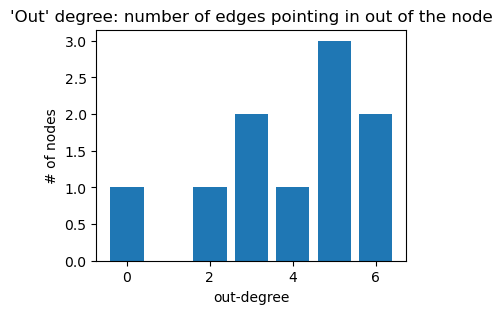

In [7]:
plt.figure(figsize=(4,3))
plt.bar(*np.unique(out_degree_sequence, return_counts=True))
plt.title("'Out' degree: number of edges pointing in out of the node")
plt.xlabel("out-degree")
plt.ylabel("# of nodes")
plt.show()

In [3]:
def multiple_interventions_by_degree(G):
    nodes_by_out_degree = [node for node, _ in sorted(G.out_degree, key=lambda x: x[1], reverse=True)]
    intervention_sets = []
    intervened_nodes_list = []

    for node in nodes_by_out_degree:
        if node not in intervened_nodes_list:
            intervention_set = [node]
            intervened_nodes_list.append(node)

            target_nodes = [v for _, v in G.out_edges(node)]
            nodes_not_target = [x for x in nodes_by_out_degree if x not in target_nodes and x!=node]

            for new_node in nodes_not_target:

                if new_node in intervened_nodes_list:
                    continue

                new_node_targets = [v for _, v in G.out_edges(new_node)]
                new_node_sources = [u for u, _ in G.in_edges(new_node)]

                if not new_node_targets: # if node has no targets
                    intervened_nodes_list.append(new_node)
                    continue

                targets_no_overlap = len(set(target_nodes + new_node_targets)) == len(new_node_targets + target_nodes)
                new_node_targets_not_in_invervention_set = len(set(new_node_targets + intervention_set)) == len(new_node_targets + intervention_set)
                new_node_sources_not_in_invervention_set = len(set(new_node_sources + intervention_set)) == len(new_node_sources + intervention_set)

                if targets_no_overlap and new_node_targets_not_in_invervention_set and new_node_sources_not_in_invervention_set:
                    target_nodes.extend(new_node_targets)
                    intervention_set.append(new_node)
                    intervened_nodes_list.append(new_node)

            intervention_sets.append(intervention_set)
    return intervention_sets

def single_intervetions_by_degree(G):
    nodes_by_out_degree = [node for node, _ in sorted(G.out_degree, key=lambda x: x[1], reverse=True)]
    return [[i] for i in nodes_by_out_degree]

In [5]:
n_obs = 10
n_hidden = 50
n_networks = 10
n_timesteps = 10**4
p=0.1
network_data = generate_networks(n_networks, n_neurons=n_obs+n_hidden, p=p)
res={}
res['by_degree'] = {'SHD':{}, 'fn':{}, 'fp':{}}
res['random'] = {'SHD':{}, 'fn':{}, 'fp':{}}
res['multi_by_degree'] = {'SHD':{}, 'fn':{}, 'fp':{}}

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

### singleton degree intervention

In [19]:
# learn the null graph
for i in range(n_networks):
    res['by_degree']['SHD'][i] = []
    res['by_degree']['fn'][i] = []
    res['by_degree']['fp'][i] = []
    
    res['multi_by_degree']['SHD'][i] = []
    res['multi_by_degree']['fn'][i] = []
    res['multi_by_degree']['fp'][i] = []
    
    res['random']['SHD'][i] = []
    res['random']['fn'][i] = []
    res['random']['fp'][i] = []

    network = network_data[i]
    index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

    spike_data = dict()
    spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)
    spike_data['null'] = spikes[index_obs]

    G = to_networkx(network)   
    G_true = nx.subgraph(G, index_obs)
    G_learned_null = observational_learner_Poisson(
        spike_data, 
        node_list=index_obs, 
        alpha = 1e-2)

    tp=count_true_positive(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)
    fp=count_false_positive(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)
    fn=count_false_negative(G_learned=G_learned_null, G_true=G_true, nodelist=index_obs)

    shd=compute_SHD(G_learned=G_learned_null,G_true=G_true)
    fp=count_false_positive(G_learned=G_learned_null,G_true=G_true, nodelist=index_obs)
    fn=count_false_negative(G_learned=G_learned_null,G_true=G_true, nodelist=index_obs)

    print('shd =',shd, 'fp =',fp, 'fn =',fn)
    
    res['by_degree']['SHD'][i].append(shd)
    res['by_degree']['fn'][i].append(fn)   
    res['by_degree']['fp'][i].append(fp)
    
    res['multi_by_degree']['SHD'][i].append(shd)
    res['multi_by_degree']['fn'][i].append(fn)   
    res['multi_by_degree']['fp'][i].append(fp)
    
    res['random']['SHD'][i].append(shd)
    res['random']['fn'][i].append(fn)   
    res['random']['fp'][i].append(fp)
    
    G_learned = G_learned_null.copy()
    
    # now learn from interventional data
    # degree protocol
    singleton_intervention_sets = single_intervetions_by_degree(G_learned_null)

    for intervention_set in singleton_intervention_sets:
        stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
        stimulus_mask[intervention_set] = True
        neuron_model.add_stimulus(lambda t: 3.5*(t % 200 < 100)*stimulus_mask)#
        spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)          

        intervention_node = intervention_set[0] #singleton intervention
        spike_data[str(intervention_node)] = spikes[index_obs]

        G_learned = interventional_learner_Poisson(
            spike_data,
            node_list=index_obs, 
            stimulation_protocol=[intervention_set],
            SCM_learned=G_learned,
            alpha = 1e-5)

        shd=compute_SHD(G_learned=G_learned,G_true=G_true)
        fp=count_false_positive(G_learned=G_learned,G_true=G_true, nodelist=index_obs)
        fn=count_false_negative(G_learned=G_learned,G_true=G_true, nodelist=index_obs)
        res['by_degree']['SHD'][i].append(shd)
        res['by_degree']['fn'][i].append(fn)   
        res['by_degree']['fp'][i].append(fp)

    G_learned = G_learned_null.copy()
    
    # now learn from interventional data
    # degree protocol
    multiple_intervention_sets = multiple_interventions_by_degree(G_learned_null)
    print(multiple_intervention_sets)
    
    for intervention_set in multiple_intervention_sets:
        stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
        stimulus_mask[intervention_set] = True
        neuron_model.add_stimulus(lambda t: 3.5*(t % 200 < 100)*stimulus_mask)#
        spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)          
        intervention_str = '_'.join(str(x) for x in intervention_set)
        spike_data[intervention_str] = spikes[index_obs]

        G_learned = interventional_learner_Poisson(
            spike_data,
            node_list=index_obs, 
            stimulation_protocol=[intervention_set],
            SCM_learned=G_learned,
            alpha = 1e-5)

        shd=compute_SHD(G_learned=G_learned,G_true=G_true)
        fp=count_false_positive(G_learned=G_learned,G_true=G_true, nodelist=index_obs)
        fn=count_false_negative(G_learned=G_learned,G_true=G_true, nodelist=index_obs)
        res['multi_by_degree']['SHD'][i].append(shd)
        res['multi_by_degree']['fn'][i].append(fn)   
        res['multi_by_degree']['fp'][i].append(fp)
    
    # random selection
    G_learned = G_learned_null.copy()
    
    # degree protocol
    random_selection = np.random.choice(index_obs, size = n_obs, replace = False)
    random_intervention_sets = [[j] for j in random_selection]

    for intervention_set in random_intervention_sets:
        stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
        stimulus_mask[intervention_set] = True
        neuron_model.add_stimulus(lambda t: 3.5*(t % 200 < 100)*stimulus_mask)#
        spikes = neuron_model.simulate(network, n_steps=n_timesteps, verbose=False)          

        intervention_node = intervention_set[0] #singleton intervention
        spike_data[str(intervention_node)] = spikes[index_obs]

        G_learned = interventional_learner_Poisson(
            spike_data,
            node_list=index_obs, 
            stimulation_protocol=[intervention_set],
            SCM_learned=G_learned,
            alpha = 1e-5)

        shd=compute_SHD(G_learned=G_learned,G_true=G_true)
        fp=count_false_positive(G_learned=G_learned,G_true=G_true, nodelist=index_obs)
        fn=count_false_negative(G_learned=G_learned,G_true=G_true, nodelist=index_obs)
        res['random']['SHD'][i].append(shd)
        res['random']['fn'][i].append(fn)   
        res['random']['fp'][i].append(fp)

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


shd = 0 fp = 0 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


[[32], [11, 41], [19, 57], [9]]


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.11it/s]


shd = 5 fp = 5 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


[[57, 6], [12, 35], [50], [22]]


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]


shd = 1 fp = 1 fn = 0


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


[[12], [34, 41], [44, 45], [3], [22], [29]]


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


shd = 4 fp = 4 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


[[23, 11, 7], [18, 21]]


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


shd = 0 fp = 0 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


[[12, 26], [34, 28], [17, 47], [19], [32]]


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


shd = 2 fp = 2 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


[[2, 18, 7], [47], [35, 0, 3, 33]]


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


shd = 1 fp = 1 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


[[47, 32, 31], [44, 53, 6], [2, 58]]


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]


shd = 1 fp = 1 fn = 0


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


[[22, 30], [10, 21, 25], [33, 41], [44]]


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]


shd = 2 fp = 2 fn = 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


[[52, 38, 2], [17, 3], [22, 56], [28, 51], [34]]


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.11it/s]


shd = 2 fp = 2 fn = 0


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


[[16, 21], [55, 34], [59]]


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


In [24]:
for i in range(n_networks):
    while len(res['multi_by_degree']['SHD'][i])<n_obs+1:
        res['multi_by_degree']['SHD'][i].append(0)

In [27]:
pd.DataFrame(res['multi_by_degree']['SHD']).fillna(0).mean(axis=1)

0     1.8
1     1.0
2     0.5
3     0.2
4     0.1
5     0.1
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
dtype: float64

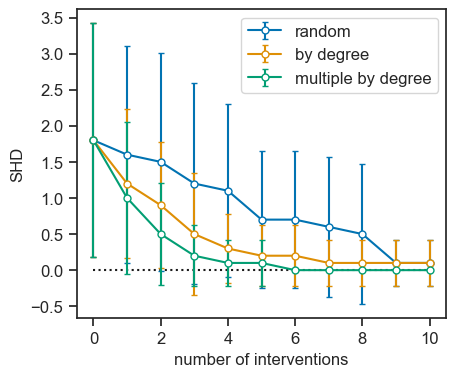

In [29]:
sns.set_theme(palette="colorblind",style="ticks",context='notebook')

cm=1/2.54
params = {
    'legend.fontsize': 12,
    'font.size': 12,
    'figure.figsize': (20*cm,10.0*cm), # figsize for two-column latex doc
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.markersize': 3.0,
    'lines.linewidth': 1.5,
    }

plt.rcParams.update(params)

shd_multi_degree_mean = pd.DataFrame(res['multi_by_degree']['SHD']).fillna(0).mean(axis=1)
shd_multi_degree_std = pd.DataFrame(res['multi_by_degree']['SHD']).fillna(0).std(axis=1)

shd_degree_mean = pd.DataFrame(res['by_degree']['SHD']).mean(axis=1)
shd_degree_std = pd.DataFrame(res['by_degree']['SHD']).std(axis=1)

shd_random_mean = pd.DataFrame(res['random']['SHD']).mean(axis=1)
shd_random_std = pd.DataFrame(res['random']['SHD']).std(axis=1)

plt.figure(figsize=(12*cm,10*cm))
#plt.plot(shd_degree_mean, label='by out-degree')
plt.hlines(y=0,xmin=0,xmax=n_obs,linestyle=':',color='k')

plt.errorbar(x=np.arange(n_obs+1), y=shd_random_mean, yerr=shd_random_std, 
             fmt='o-', capsize=2, markerfacecolor='white', markersize=5, label='random')
plt.errorbar(x=np.arange(n_obs+1), y=shd_degree_mean, yerr=shd_degree_std, 
             fmt='o-', capsize=2, markerfacecolor='white', markersize=5, label='by degree')
plt.errorbar(x=np.arange(n_obs+1), y=shd_multi_degree_mean, yerr=shd_multi_degree_std, 
             fmt='o-', capsize=2, markerfacecolor='white', markersize=5, label='multiple by degree')
plt.xlabel('number of interventions')
plt.ylabel('SHD')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/shd_by_int.pdf')

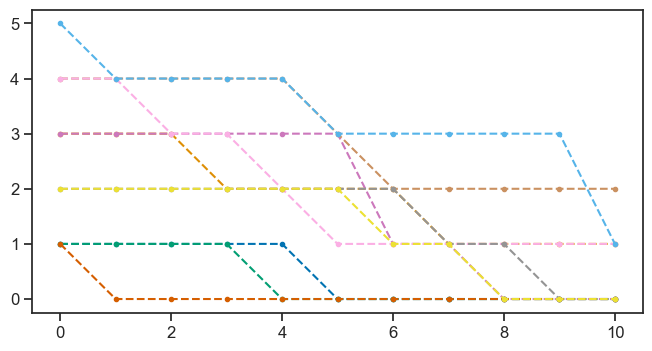

In [18]:
for i in range(n_networks):
    plt.plot(res['random']['SHD'][i],'o--')
plt.show()

### Done